# Implementing Shor's Algorithm for N = 15

In [1]:
# Following a Qiskit Textbook tutorial: https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb

import numpy as np
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from numpy.random import randint
import pandas as pd
from fractions import Fraction

print("Imports Successful")

Imports Successful


## This starts with a circuit implementing Quantum Phase Estimation.
## First, a circuit implementing $U^x$ where $U$ is the unitary operator $U\vert y\rangle = \vert ay \bmod N \rangle$:

In [2]:
def c_amod15(a, power):
    """The circuit for controlled multiplication by a mod 15, repeated power times."""
    # Note: different gates are used based on the value of a
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    # Creating an empty circuit with 4 qubits
    U = QuantumCircuit(4)
    # Repeating U `power` times where the gates composing U depends on `a`
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    # Convert the circuit we just built into a gate
    U = U.to_gate()
    # Name the gate for displaying purposes
    U.name = f"{a}^{power} mod 15"
    # Return a controlled version of the gate
    c_U = U.control()
    return c_U

## Defining the number of qubits we will be using: 8
<!-- ### (4 for the quantum register and 4 for the classical register) -->

In [3]:
# Specify variables
N_COUNT = 8  # number of counting qubits

## Next, a circuit implementing the inverse Quantum Fourier Transform:

In [4]:
def qft_dagger(n):
    """The circuit for QFT† on n qubits."""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

## Visualizing the entire circuit for $a = 7$:

In [5]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to use in it's subcircuit
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)
a = 7


# First, initialize counting qubits in state |+>
for q in range(N_COUNT):
    qc.h(q)

# and auxiliary register in state |1>
qc.x(N_COUNT)

# Then, perform the controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Then, perform the inverse QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Finally, measure all the counting qubits
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

## Visualizing the distribution of outputs over 1000 runs of the circuit:

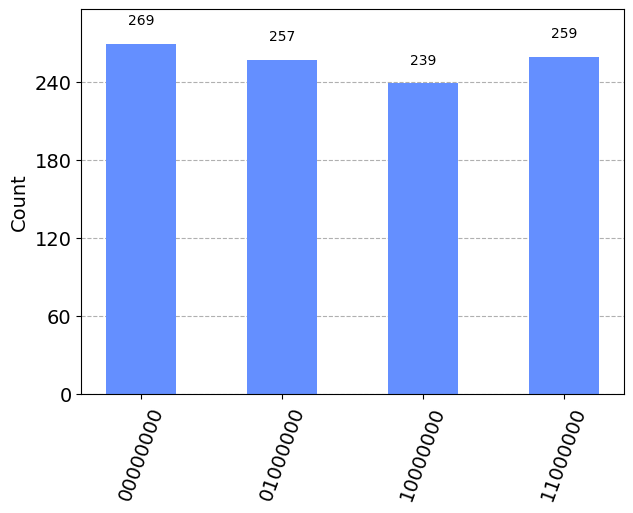

In [6]:
# here we are simulating the circuit 1000 times and reading outputs.
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

## Obtaining a phase estimation from the circuit outputs:

In [7]:
rows, measured_phases = [], []
# here phase means the measured output divided by N, i.e s/N ~= k/L
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) bitstring to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue by dividing by 2^n
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  00000000(bin) =   0(dec)    0/256 = 0.00


## Using phase estimation to guess the order of $a$ modulo $N$:

In [8]:
rows = []
for phase in measured_phases:
    # Performing continued fraction approximation up to N = 15
    frac = Fraction(phase).limit_denominator(15)
    # The fraction is approximated to some s/L where L is what we want
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for L"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for L
0   0.50      1/2            2
1   0.75      3/4            4
2   0.25      1/4            4
3   0.00      0/1            1


# Now, to factoring $N = 15$...

In [9]:
# Re-asserting N = 15
N = 15

## by finding $L$ in $a^L$ modulo $N$ for some random $a$:

In [10]:
# Selecting a random number a < N
a = randint(2, 15)
print(f"Chosen a={a}")

Chosen a=3


### If $a$ isn't coprime to $N$, we have a factor of $N$ already:

In [11]:
from math import gcd # greatest common divisor

# Demonstrating what happens if a is not coprime with N
a = 6

greatest_common_divisor = gcd(a, N)

print(f"a is {a}")
print(f"Found a factor of {N}: {greatest_common_divisor}")
print(f"Factors of {N}: {greatest_common_divisor}, {N//greatest_common_divisor}")

a is 6
Found a factor of 15: 3
Factors of 15: 3, 5


## For demonstration, selecting a random $a$ that is coprime to $N$:

In [12]:
def get_coprime_a():
    """Returns a coprime value for `a` for N=15"""
    # A list of all coprime values for N=15
    possible_a_values_for_N_15 = [2, 4, 7, 8, 11, 13]

    # Selecting a random index from the list of possible values
    index = randint(1, len(possible_a_values_for_N_15))

    # Returning the coprime value for `a`
    a = possible_a_values_for_N_15[index]
    print(f"Chosen a={a}")
    return a

## Redefining our quantum phase estimation circuit to work with random values of $a$:

In [13]:
def qpe_amod15(a):
    """Creates the circuit for performing quantum phase estimation on the operation a*r mod 15 and returns the phase.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    # Number of qubits
    N_COUNT = 8
    # Creating an empty circuit with N_COUNT counting qubits and 4 qubits for U
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)

    # Initialize counting qubits in state |+>
    for q in range(N_COUNT):
        qc.h(q)
    # and auxiliary register in state |1>
    qc.x(3+N_COUNT)

    # Then, perform controlled-U operations
    for q in range(N_COUNT):
        qc.append(c_amod15(a, 2**q), [q] + [i+N_COUNT for i in range(4)])
    
    # Then, perform the inverse QFT
    qc.append(qft_dagger(N_COUNT), range(N_COUNT))

    # Finally, measure all the counting qubits
    qc.measure(range(N_COUNT), range(N_COUNT))


    # Simulate running the circuit
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    # Get the list of measurements
    readings = job.result().get_memory()
    # Read the first measurement (we only ran the circuit once, so this is the only measurement)
    print("Circuit Output: " + readings[0])
    # Convert the bitstring into decimal and divide it by 2^n, like we did above
    phase = int(readings[0],2)/(2**N_COUNT)
    # Return the phase
    print(f"Corresponding Phase: {phase}")
    return phase

## Running the circuit for our random $a$, obtaining $L$ via continued fraction approximation, and guessing the factors of $N$:

In [14]:
a = get_coprime_a()
print(f"a = {a}")
phase = qpe_amod15(a) # Phase = k/L
frac = Fraction(phase).limit_denominator(15)
s, L = frac.numerator, frac.denominator
print(f"L = {L}")
guesses = [gcd(a**(L//2)-1, N), gcd(a**(L//2)+1, N)]
print(f"Guessed Factors: {guesses}")

if 3 in guesses and 5 in guesses:
    print("Success!")
else:
    print("Unsuccessful, try again.")

Chosen a=7
a = 7


Circuit Output: 01000000
Corresponding Phase: 0.25
L = 4
Guessed Factors: [3, 5]
Success!
